In [4]:
import os
import glob
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from skimage import io, color
from skimage.measure import regionprops, label
from skimage.filters import threshold_otsu
from sklearn.feature_selection import RFE
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Set the root path to your dataset
root_path = '/content/drive/MyDrive/New_Rice_image_Dataset75000/Rice_Image_Dataset'

# Get the class names from subdirectories
class_names = (os.listdir(root_path))

print("class names-> ",class_names)
print()

# Collect file paths and labels
file_paths = []
labels = []

for class_name in class_names:
    class_path = os.path.join(root_path, class_name)
    file_paths.extend(glob.glob(os.path.join(class_path, '*.jpg')))
    labels.extend([class_name] * len(glob.glob(os.path.join(class_path, '*.jpg'))))

# Create a DataFrame
data = pd.DataFrame({'Filepath': file_paths, 'Label': labels})
print('DATAFRAME SAMPLES:')
print(data)
print()
print('=========================================================================')




class names->  ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']

DATAFRAME SAMPLES:
                                                Filepath      Label
0      /content/drive/MyDrive/New_Rice_image_Dataset7...    Arborio
1      /content/drive/MyDrive/New_Rice_image_Dataset7...    Arborio
2      /content/drive/MyDrive/New_Rice_image_Dataset7...    Arborio
3      /content/drive/MyDrive/New_Rice_image_Dataset7...    Arborio
4      /content/drive/MyDrive/New_Rice_image_Dataset7...    Arborio
...                                                  ...        ...
74995  /content/drive/MyDrive/New_Rice_image_Dataset7...  Karacadag
74996  /content/drive/MyDrive/New_Rice_image_Dataset7...  Karacadag
74997  /content/drive/MyDrive/New_Rice_image_Dataset7...  Karacadag
74998  /content/drive/MyDrive/New_Rice_image_Dataset7...  Karacadag
74999  /content/drive/MyDrive/New_Rice_image_Dataset7...  Karacadag

[75000 rows x 2 columns]



In [ ]:
# Segmentation and Feature Extraction
cnt=0

def extract_custom_features(image_path):
   # global cnt
   # cnt+=1
   # print(cnt)

    # Read the image using io.imread from skimage
    image = io.imread(image_path)

    # Convert the image to grayscale using rgb2gray from skimage.color
    gray_image = color.rgb2gray(image)

    # Apply Otsu's thresholding method to create a binary image
    binary_image = gray_image > threshold_otsu(gray_image)

    # Label connected components in the binary image
    labeled_image = label(binary_image)

    # Calculate region properties of labeled components using regionprops from skimage.measure
    props = regionprops(labeled_image)

    # Extract specific features from the region properties
    area = props[0].area
    perimeter = props[0].perimeter
    major_axis = props[0].major_axis_length
    minor_axis = props[0].minor_axis_length
    eccentricity = props[0].eccentricity
    convex_area = props[0].convex_area
    extent = props[0].extent
    solidity = props[0].solidity
    orientation = props[0].orientation
    equivalent_diameter = props[0].equivalent_diameter
    compactness = (perimeter ** 2) / (4 * 3.1416 * area) if area != 0 else 0

    # Calculate aspect ratio
    aspect_ratio = major_axis / minor_axis if minor_axis != 0 else 0

    # Calculate roundness
    roundness = (4 * area) / (3.1416 * (major_axis ** 2)) if major_axis != 0 else 0

    # Return the extracted features as a list
    return [area, perimeter, major_axis, minor_axis, eccentricity, convex_area, extent,
            solidity, orientation, equivalent_diameter, compactness, aspect_ratio, roundness]

# Apply the function to each image in the 'Filepath' column
data['custom_features'] = data['Filepath'].apply(extract_custom_features)

# Unpack the updated custom features into separate columns
data[['area', 'perimeter', 'major_axis', 'minor_axis', 'eccentricity', 'convex_area', 'extent',
      'solidity', 'orientation', 'equivalent_diameter', 'compactness', 'aspect_ratio', 'roundness']] = pd.DataFrame(data['custom_features'].tolist(), index=data.index)

# Drop the temporary 'custom_features' column
data = data.drop(columns=['custom_features'])

# Write all features including the new ones to an Excel sheet
output_path = '/content/drive/MyDrive/FEATURES_ALL_MORPHOLOGY.xlsx'
data.to_excel(output_path, index=False)

print(f"All features including 'aspect_ratio' and 'roundness' written to {output_path}")

# Split the dataset into train and test sets
train, test = train_test_split(data, test_size=0.25, random_state=42)
# Convert labels to numerical values
label_encoder = LabelEncoder()
train['Label'] = label_encoder.fit_transform(train['Label'])
test['Label'] = label_encoder.transform(test['Label'])
# Extract features and labels
X_train = train[['area', 'perimeter', 'major_axis', 'minor_axis', 'eccentricity', 'convex_area', 'extent',
                 'solidity', 'orientation', 'equivalent_diameter', 'compactness', 'aspect_ratio', 'roundness']]
y_train = train['Label']
X_test = test[['area', 'perimeter', 'major_axis', 'minor_axis', 'eccentricity', 'convex_area', 'extent',
                'solidity', 'orientation', 'equivalent_diameter', 'compactness', 'aspect_ratio', 'roundness']]
y_test = test['Label']

In [ ]:
print(data.head(3))

                                            Filepath    Label  area  \
0  /content/drive/MyDrive/New_Rice_image_Dataset7...  Arborio  7835   
1  /content/drive/MyDrive/New_Rice_image_Dataset7...  Arborio  7625   
2  /content/drive/MyDrive/New_Rice_image_Dataset7...  Arborio  6859   

    perimeter  major_axis  minor_axis  eccentricity  convex_area    extent  \
0  366.132034  138.316059   73.319444      0.847944         8076  0.625050   
1  361.989899  136.584527   72.428102      0.847822         7872  0.635417   
2  342.936075  135.926020   64.750742      0.879246         6986  0.763979   

   solidity  orientation  equivalent_diameter  compactness  aspect_ratio  \
0  0.970158     0.728242            99.879086     1.361525      1.886485   
1  0.968623    -0.622096            98.531475     1.367547      1.885795   
2  0.981821    -0.113684            93.451324     1.364441      2.099220   

   roundness  
0   0.521438  
1   0.520410  
2   0.472677  


Accuracy with selected features: 0.96848

Classification Report (Selected Features):
              precision    recall  f1-score   support

     Arborio       0.97      0.96      0.97      3763
     Basmati       0.96      0.95      0.96      3729
      Ipsala       1.00      0.99      1.00      3882
     Jasmine       0.94      0.96      0.95      3694
   Karacadag       0.96      0.98      0.97      3682

    accuracy                           0.97     18750
   macro avg       0.97      0.97      0.97     18750
weighted avg       0.97      0.97      0.97     18750


Confusion Matrix (Selected Features):
[[3618    0    1   10  134]
 [   0 3539    0  190    0]
 [  10    0 3862   10    0]
 [   8  131    6 3548    1]
 [  90    0    0    0 3592]]


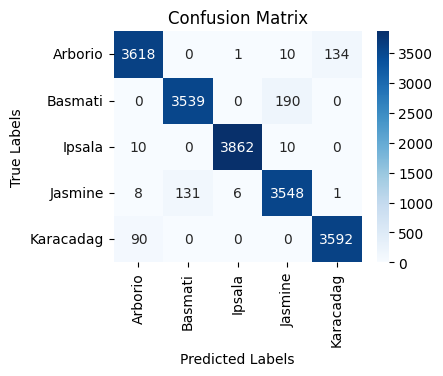

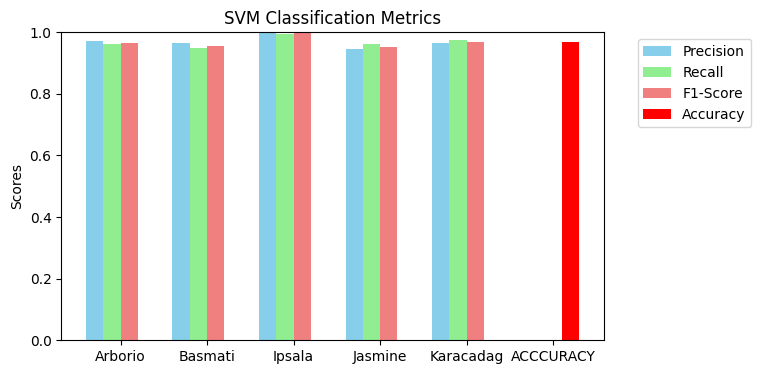

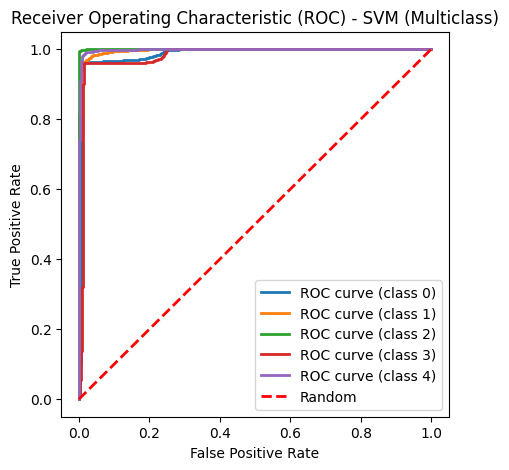

In [ ]:
# 1) SVM - Linear kernel

# Initialize SVM classifier
clf_svm = svm.SVC(kernel='linear')

# Initialize RFE
rfe = RFE(estimator=clf_svm, n_features_to_select=5, step=1)  # Select top 5 features (you can change this value)

# Fit RFE to training data
rfe.fit(X_train, y_train)

# Get selected features
selected_features = X_train.columns[rfe.support_]

# Use only the selected features for training and testing
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Train the SVM model using selected features
clf_svm.fit(X_train_selected, y_train)

# Predict on the test set using the selected features
y_pred_selected = clf_svm.predict(X_test_selected)

# Evaluate the model with selected features
accuracy_selected = accuracy_score(y_test, y_pred_selected)
print(f'Accuracy with selected features: {accuracy_selected}')

# Display classification report and confusion matrix for selected features
print('\nClassification Report (Selected Features):')
print(classification_report(y_test, y_pred_selected, target_names=class_names))

print('\nConfusion Matrix (Selected Features):')
c_selected = confusion_matrix(y_test, y_pred_selected)
print(c_selected)
#===============================================================================
# Plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(4, 3))
sns.heatmap(c_selected, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
print()
#===============================================================================
# Bar chart

import numpy as np

width=0.2
x = np.arange(len(class_names) + 1)  # Added 1 for the common bar
classification_rep_logreg = classification_report(y_test, y_pred_selected, target_names=class_names, output_dict=True)

# Extract precision, recall, f1_score, and accuracy
precision_logreg = [classification_rep_logreg[class_name]['precision'] for class_name in class_names]
recall_logreg = [classification_rep_logreg[class_name]['recall'] for class_name in class_names]
f1_score_logreg = [classification_rep_logreg[class_name]['f1-score'] for class_name in class_names]
accuracy_logreg = classification_rep_logreg['accuracy']

# Plot metrics
fig, ax = plt.subplots(figsize=(7, 4))

# Bar plot for precision
ax.bar(x - width, precision_logreg + [0], width, label='Precision', color='blue')

# Bar plot for recall
ax.bar(x, recall_logreg + [0], width, label='Recall', color='orange')

# Bar plot for F1-score
ax.bar(x + width, f1_score_logreg + [0], width, label='F1-Score', color='green')

# Single common bar for accuracy
ax.bar(len(class_names) + 1.5 * width, [accuracy_logreg], width, color='red', label='Accuracy')

# Set y-axis limits
ax.set_ylim(0, 1)

# Set labels and title
ax.set_ylabel('Scores')
ax.set_title('SVM Classification Metrics')
ax.set_xticks(x + width / 2)
ax.set_xticklabels(class_names + ['ACCCURACY'])
ax.legend()

# Place the legend outside the plot area
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()
print()
#===============================================================================
# ROC curve

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Binarize the output
y_test_binarized = label_binarize(y_test, classes=list(range(len(class_names))))

# Get decision function scores
y_scores = clf_svm.decision_function(X_test_selected)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting ROC curves for each class
plt.figure(figsize=(5, 5))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (class {})'.format(i))

plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - SVM (Multiclass)')
plt.legend(loc='lower right')
plt.show()


Accuracy with selected features using RFE: 0.9750933333333334

Classification Report (Selected Features using RFE):
              precision    recall  f1-score   support

     Arborio       0.97      0.96      0.96      3763
     Basmati       0.97      0.98      0.98      3729
      Ipsala       1.00      0.99      1.00      3882
     Jasmine       0.97      0.97      0.97      3694
   Karacadag       0.96      0.97      0.97      3682

    accuracy                           0.98     18750
   macro avg       0.97      0.97      0.97     18750
weighted avg       0.98      0.98      0.98     18750


Confusion Matrix (Selected Features using RFE):
[[3601    0    7    8  147]
 [   0 3654    0   75    0]
 [   7    0 3862   13    0]
 [   7   97    7 3582    1]
 [  98    0    0    0 3584]]


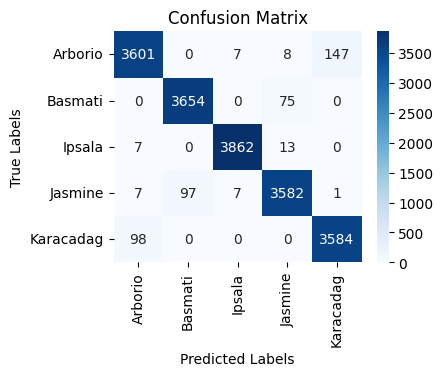

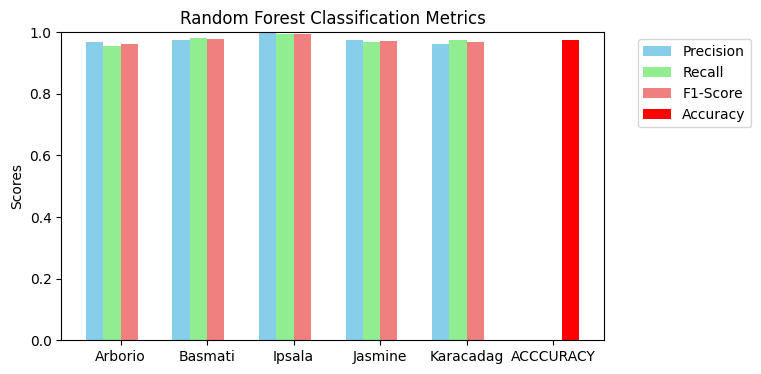

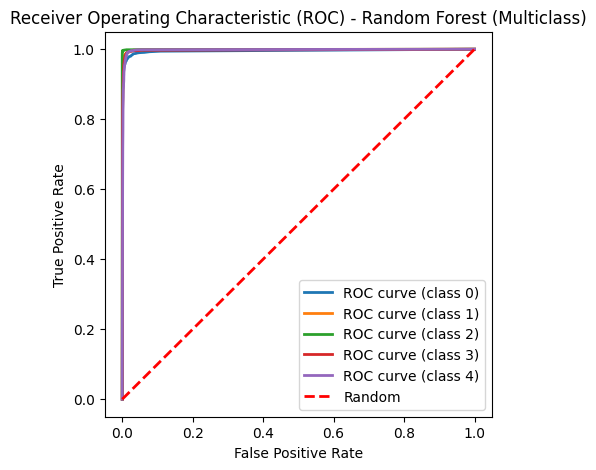

In [ ]:
# 2) Random Forest

from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize Random Forest classifier
clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Initialize RFE
rfe_rf = RFE(estimator=clf_rf, n_features_to_select=9, step=1) #<-------------

# Fit RFE to training data
rfe_rf.fit(X_train, y_train)

# Get selected features
selected_features_rf = X_train.columns[rfe_rf.support_]

# Use only the selected features for training and testing
X_train_selected_rf = X_train[selected_features_rf]
X_test_selected_rf = X_test[selected_features_rf]

# Train the Random Forest model using selected features
clf_rf.fit(X_train_selected_rf, y_train)

# Predict on the test set using selected features
y_pred_selected_rf = clf_rf.predict(X_test_selected_rf)

# Evaluate the model with selected features
accuracy_selected_rf = accuracy_score(y_test, y_pred_selected_rf)
print(f'Accuracy with selected features using RFE: {accuracy_selected_rf}')

# Display classification report and confusion matrix for selected features
print('\nClassification Report (Selected Features using RFE):')
print(classification_report(y_test, y_pred_selected_rf, target_names=class_names))

print('\nConfusion Matrix (Selected Features using RFE):')
c_selected_rf = confusion_matrix(y_test, y_pred_selected_rf)
print(c_selected_rf)

#===============================================================================
# Plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(4, 3))
sns.heatmap(c_selected_rf, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
print()
#===============================================================================
# BAR chart
import numpy as np

width=0.2
x = np.arange(len(class_names) + 1)  # Added 1 for the common bar
classification_rep_logreg = classification_report(y_test, y_pred_selected_rf, target_names=class_names, output_dict=True)

# Extract precision, recall, f1_score, and accuracy
precision_logreg = [classification_rep_logreg[class_name]['precision'] for class_name in class_names]
recall_logreg = [classification_rep_logreg[class_name]['recall'] for class_name in class_names]
f1_score_logreg = [classification_rep_logreg[class_name]['f1-score'] for class_name in class_names]
accuracy_logreg = classification_rep_logreg['accuracy']

# Plot metrics
fig, ax = plt.subplots(figsize=(7, 4))

# Bar plot for precision
ax.bar(x - width, precision_logreg + [0], width, label='Precision', color='skyblue')

# Bar plot for recall
ax.bar(x, recall_logreg + [0], width, label='Recall', color='lightgreen')

# Bar plot for F1-score
ax.bar(x + width, f1_score_logreg + [0], width, label='F1-Score', color='lightcoral')

# Single common bar for accuracy
ax.bar(len(class_names) + 1.5 * width, [accuracy_logreg], width, color='red', label='Accuracy')

# Set y-axis limits
ax.set_ylim(0, 1)

# Set labels and title
ax.set_ylabel('Scores')
ax.set_title('Random Forest Classification Metrics')
ax.set_xticks(x + width / 2)
ax.set_xticklabels(class_names + ['ACCCURACY'])
ax.legend()

# Place the legend outside the plot area
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()
print()
#===============================================================================
# ROC curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Binarize the output
y_test_binarized_rf = label_binarize(y_test, classes=list(range(len(class_names))))

# Get predicted probabilities for each class
y_probs_rf = clf_rf.predict_proba(X_test_selected_rf)

# Compute ROC curve and ROC area for each class
fpr_rf = dict()
tpr_rf = dict()
roc_auc_rf = dict()

for i in range(len(class_names)):
    fpr_rf[i], tpr_rf[i], _ = roc_curve(y_test_binarized_rf[:, i], y_probs_rf[:, i])
    roc_auc_rf[i] = auc(fpr_rf[i], tpr_rf[i])

# Plotting ROC curves for each class
plt.figure(figsize=(5,5))
for i in range(len(class_names)):
    plt.plot(fpr_rf[i], tpr_rf[i], lw=2, label='ROC curve (class {})'.format(i))

plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Random Forest (Multiclass)')
plt.legend(loc='lower right')
plt.show()





Accuracy with selected features using RFE and Logistic Regression: 0.9604266666666667

Classification Report (Selected Features using RFE and Logistic Regression):
              precision    recall  f1-score   support

     Arborio       0.96      0.94      0.95      3763
     Basmati       0.96      0.95      0.95      3729
      Ipsala       1.00      0.99      0.99      3882
     Jasmine       0.94      0.95      0.95      3694
   Karacadag       0.94      0.98      0.96      3682

    accuracy                           0.96     18750
   macro avg       0.96      0.96      0.96     18750
weighted avg       0.96      0.96      0.96     18750


Confusion Matrix (Selected Features using RFE and Logistic Regression):
[[3528    0    4   25  206]
 [   0 3531    0  198    0]
 [  43    0 3834    5    0]
 [  19  135   11 3525    4]
 [  92    0    0    0 3590]]


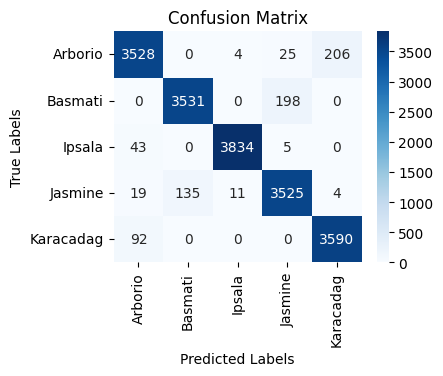

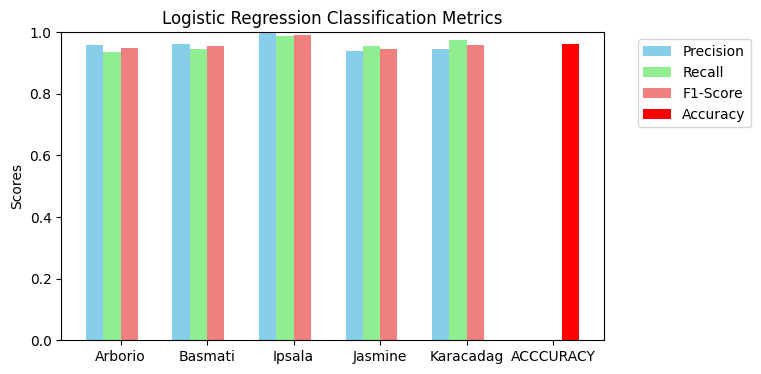

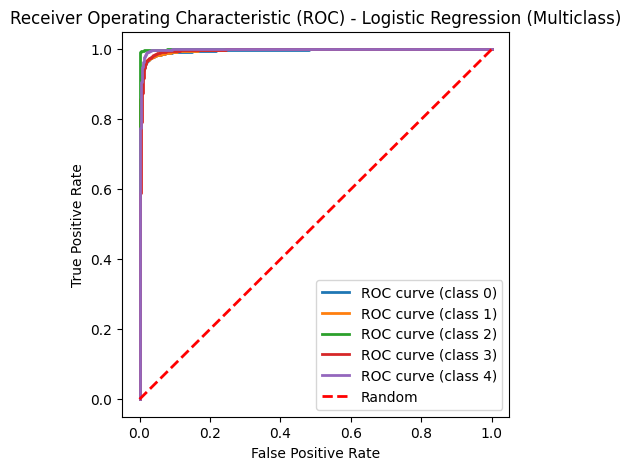

In [ ]:
# 3) Logistic regression

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize Logistic Regression classifier
clf_lr = LogisticRegression(max_iter=14000, solver='saga')  # or 'sag'

# Initialize RFE for Logistic Regression
rfe_lr = RFE(estimator=clf_lr, n_features_to_select=5, step=1) # <------------------------

# Fit RFE to training data
rfe_lr.fit(X_train, y_train)

# Get selected features
selected_features_lr = X_train.columns[rfe_lr.support_]

# Use only the selected features for training and testing
X_train_selected_lr = X_train[selected_features_lr]
X_test_selected_lr = X_test[selected_features_lr]

# Train the Logistic Regression model using selected features
clf_lr.fit(X_train_selected_lr, y_train)

# Predict on the test set using selected features
y_pred_selected_lr = clf_lr.predict(X_test_selected_lr)

# Evaluate the model with selected features
accuracy_selected_lr = accuracy_score(y_test, y_pred_selected_lr)
print(f'Accuracy with selected features using RFE and Logistic Regression: {accuracy_selected_lr}')

# Display classification report and confusion matrix for selected features
print('\nClassification Report (Selected Features using RFE and Logistic Regression):')
print(classification_report(y_test, y_pred_selected_lr, target_names=class_names))

print('\nConfusion Matrix (Selected Features using RFE and Logistic Regression):')
c_selected_lr = confusion_matrix(y_test, y_pred_selected_lr)
print(c_selected_lr)

#===============================================================================
# Plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(4, 3))
sns.heatmap(c_selected_lr, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
print()
#===============================================================================
# BAR chart

width=0.2
x = np.arange(len(class_names) + 1)  # Added 1 for the common bar
classification_rep_logreg = classification_report(y_test, y_pred_selected_lr, target_names=class_names, output_dict=True)

# Extract precision, recall, f1_score, and accuracy
precision_logreg = [classification_rep_logreg[class_name]['precision'] for class_name in class_names]
recall_logreg = [classification_rep_logreg[class_name]['recall'] for class_name in class_names]
f1_score_logreg = [classification_rep_logreg[class_name]['f1-score'] for class_name in class_names]
accuracy_logreg = classification_rep_logreg['accuracy']

# Plot metrics
fig, ax = plt.subplots(figsize=(7, 4))

# Bar plot for precision
ax.bar(x - width, precision_logreg + [0], width, label='Precision', color='skyblue')

# Bar plot for recall
ax.bar(x, recall_logreg + [0], width, label='Recall', color='lightgreen')

# Bar plot for F1-score
ax.bar(x + width, f1_score_logreg + [0], width, label='F1-Score', color='lightcoral')

# Single common bar for accuracy
ax.bar(len(class_names) + 1.5 * width, [accuracy_logreg], width, color='red', label='Accuracy')

# Set y-axis limits
ax.set_ylim(0, 1)

# Set labels and title
ax.set_ylabel('Scores')
ax.set_title('Logistic Regression Classification Metrics')
ax.set_xticks(x + width / 2)
ax.set_xticklabels(class_names + ['ACCCURACY'])
ax.legend()

# Place the legend outside the plot area
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()
print()
#===============================================================================
# ROC curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Binarize the output
y_test_binarized_lr = label_binarize(y_test, classes=list(range(len(class_names))))

# Get predicted probabilities for each class
y_probs_lr = clf_lr.predict_proba(X_test_selected_lr)

# Compute ROC curve and ROC area for each class
fpr_lr = dict()
tpr_lr = dict()
roc_auc_lr = dict()

for i in range(len(class_names)):
    fpr_lr[i], tpr_lr[i], _ = roc_curve(y_test_binarized_lr[:, i], y_probs_lr[:, i])
    roc_auc_lr[i] = auc(fpr_lr[i], tpr_lr[i])

# Plotting ROC curves for each class
plt.figure(figsize=(5, 5))
for i in range(len(class_names)):
    plt.plot(fpr_lr[i], tpr_lr[i], lw=2, label='ROC curve (class {})'.format(i))

plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Logistic Regression (Multiclass)')
plt.legend(loc='lower right')
plt.show()


Accuracy after scaling: 0.96992

Classification Report after scaling:
              precision    recall  f1-score   support

     Arborio       0.97      0.96      0.96      3763
     Basmati       0.98      0.95      0.97      3729
      Ipsala       1.00      0.99      0.99      3882
     Jasmine       0.94      0.98      0.96      3694
   Karacadag       0.96      0.97      0.97      3682

    accuracy                           0.97     18750
   macro avg       0.97      0.97      0.97     18750
weighted avg       0.97      0.97      0.97     18750


Confusion Matrix after scaling:
[[3603    0    0   18  142]
 [   0 3560    0  169    0]
 [  17    0 3840   25    0]
 [   0   79    1 3613    1]
 [ 112    0    0    0 3570]]


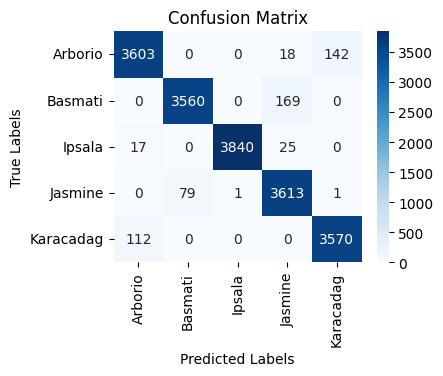

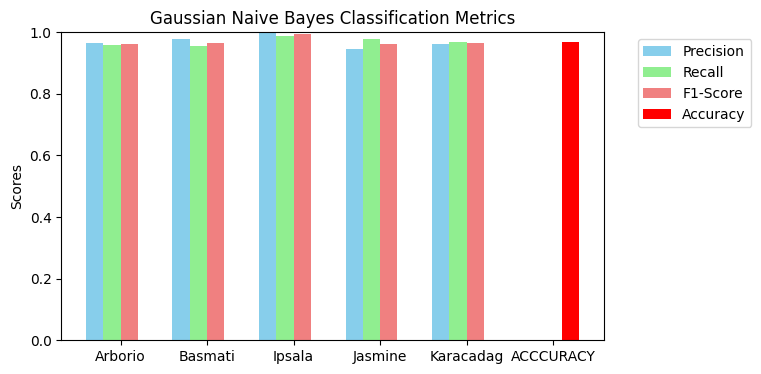

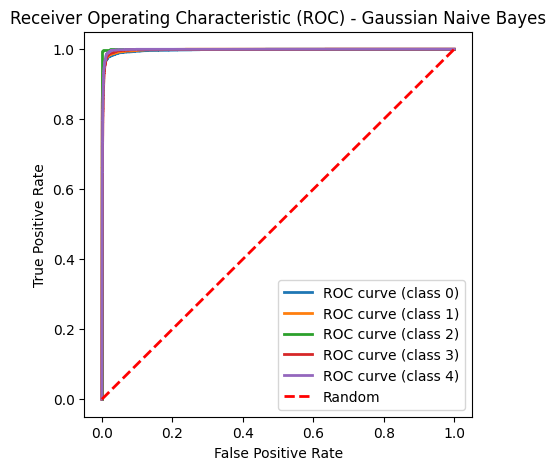

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# Initialize the StandardScaler
scaler = StandardScaler()

# Fit on training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize Gaussian Naive Bayes classifier
gnb = GaussianNB()

# Train the Gaussian Naive Bayes model on scaled data
gnb.fit(X_train_scaled, y_train)

# Predict on the scaled test set
y_pred_scaled = gnb.predict(X_test_scaled)

# Evaluate the model
accuracy_scaled = accuracy_score(y_test, y_pred_scaled)
print(f'Accuracy after scaling: {accuracy_scaled}')

# Display classification report and confusion matrix
print('\nClassification Report after scaling:')
print(classification_report(y_test, y_pred_scaled, target_names=class_names))

print('\nConfusion Matrix after scaling:')
c_scaled = confusion_matrix(y_test, y_pred_scaled)
print(c_scaled)

#===============================================================================
#Plot Confusion Matrix
plt.figure(figsize=(4, 3))
sns.heatmap(c_scaled, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

#===============================================================================
# BAR chart

import numpy as np

width = 0.2
x = np.arange(len(class_names) + 1)  # Added 1 for the common bar

# Get classification report for Gaussian Naive Bayes
classification_rep_gnb = classification_report(y_test, y_pred_scaled, target_names=class_names, output_dict=True)

# Extract precision, recall, f1_score, and accuracy
precision_gnb = [classification_rep_gnb[class_name]['precision'] for class_name in class_names]
recall_gnb = [classification_rep_gnb[class_name]['recall'] for class_name in class_names]
f1_score_gnb = [classification_rep_gnb[class_name]['f1-score'] for class_name in class_names]
accuracy_gnb = classification_rep_gnb['accuracy']

# Plot metrics
fig, ax = plt.subplots(figsize=(7,4))

# Bar plot for precision
ax.bar(x - width, precision_gnb + [0], width, label='Precision', color='skyblue')

# Bar plot for recall
ax.bar(x, recall_gnb + [0], width, label='Recall', color='lightgreen')

# Bar plot for F1-score
ax.bar(x + width, f1_score_gnb + [0], width, label='F1-Score', color='lightcoral')

# Single common bar for accuracy
ax.bar(len(class_names) + 1.5 * width, [accuracy_gnb], width, color='red', label='Accuracy')

# Set y-axis limits
ax.set_ylim(0, 1)

# Set labels and title
ax.set_ylabel('Scores')
ax.set_title('Gaussian Naive Bayes Classification Metrics')
ax.set_xticks(x + width / 2)
ax.set_xticklabels(class_names + ['ACCCURACY'])
ax.legend()

# Place the legend outside the plot area
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

#===============================================================================
# Plot RoC curve

from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt



# Assuming gnb is your trained Gaussian Naive Bayes classifier
# Assuming X_test_scaled and y_test are your scaled test dataset with multiclass labels

# Train a Gaussian Naive Bayes classifier
gnb.fit(X_train_scaled, y_train)

# Binarize the output
y_test_binarized_gnb = label_binarize(y_test, classes=list(range(len(class_names))))

# Get class probabilities
y_scores_gnb = gnb.predict_proba(X_test_scaled)

# Compute ROC curve and ROC area for each class
fpr_gnb = dict()
tpr_gnb = dict()
roc_auc_gnb = dict()

for i in range(len(class_names)):
    fpr_gnb[i], tpr_gnb[i], _ = roc_curve(y_test_binarized_gnb[:, i], y_scores_gnb[:, i])
    roc_auc_gnb[i] = auc(fpr_gnb[i], tpr_gnb[i])

# Plotting ROC curves for each class
plt.figure(figsize=(5,5))
for i in range(len(class_names)):
    plt.plot(fpr_gnb[i], tpr_gnb[i], lw=2, label='ROC curve (class {})'.format(i))

plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Gaussian Naive Bayes')
plt.legend(loc='lower right')
plt.show()


Accuracy after pruning and RFE using entropy: 0.97488

Classification Report after pruning and RFE using entropy:
              precision    recall  f1-score   support

     Arborio       0.97      0.96      0.96      3763
     Basmati       0.98      0.98      0.98      3729
      Ipsala       1.00      0.99      1.00      3882
     Jasmine       0.97      0.97      0.97      3694
   Karacadag       0.96      0.97      0.97      3682

    accuracy                           0.97     18750
   macro avg       0.97      0.97      0.97     18750
weighted avg       0.97      0.97      0.97     18750


Confusion Matrix after pruning and RFE using entropy:
[[3612    0    3   11  137]
 [   1 3646    0   82    0]
 [  13    0 3854   15    0]
 [   3   92    3 3595    1]
 [ 110    0    0    0 3572]]



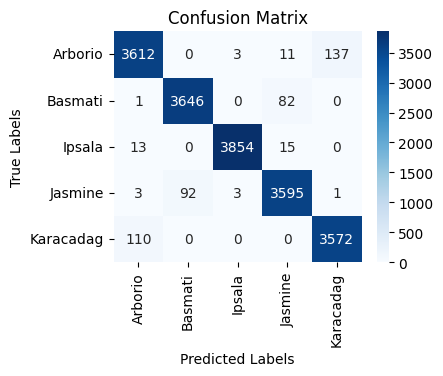

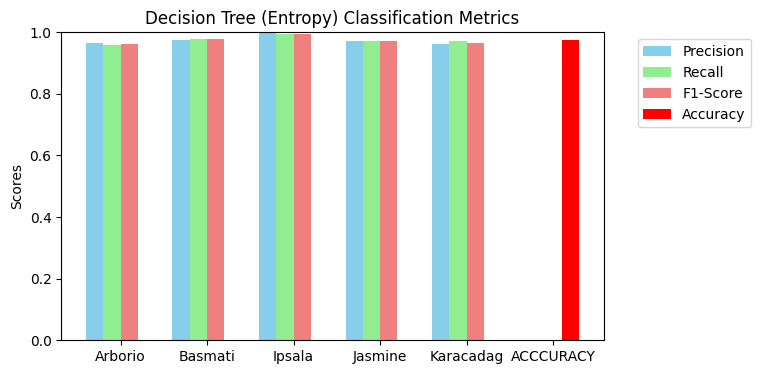

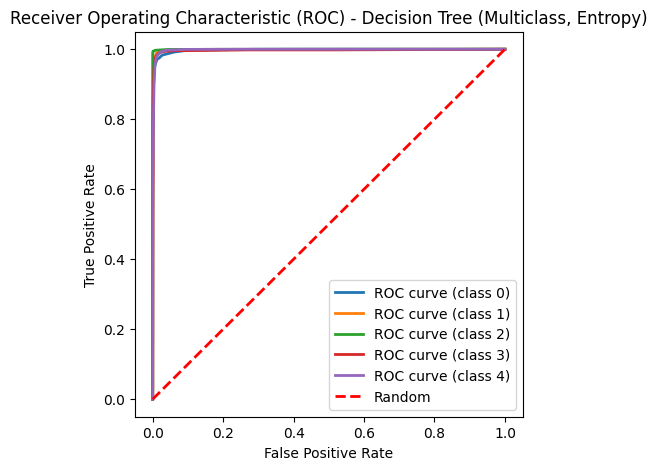

In [ ]:
# 4.2) Decision Tree (Entropy)

from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Build the Decision Tree with Entropy criterion
clf_entropy = DecisionTreeClassifier(criterion='entropy', random_state=42)
clf_entropy.fit(X_train, y_train)

# Apply Reduced Error Pruning (REP)
path = clf_entropy.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

param_grid = {'ccp_alpha': ccp_alphas}
grid_search = GridSearchCV(estimator=DecisionTreeClassifier(criterion='entropy', random_state=42),
                           param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_ccp_alpha = grid_search.best_params_['ccp_alpha']

clf_entropy_pruned = DecisionTreeClassifier(criterion='entropy', ccp_alpha=best_ccp_alpha, random_state=42)
clf_entropy_pruned.fit(X_train, y_train)

# Perform RFE after Pruning
rfe_entropy = RFE(estimator=clf_entropy_pruned, n_features_to_select=6) #  <--------------------------------------------
rfe_entropy.fit(X_train, y_train)

# Get selected features
selected_features_entropy = X_train.columns[rfe_entropy.support_]

# Use only the selected features for training and testing
X_train_selected_entropy = rfe_entropy.transform(X_train)
X_test_selected_entropy = rfe_entropy.transform(X_test)

# Train the Decision Tree model using selected features after pruning and RFE
clf_final_entropy = DecisionTreeClassifier(criterion='entropy', ccp_alpha=best_ccp_alpha, random_state=42)
clf_final_entropy.fit(X_train_selected_entropy, y_train)

# Predict on the test set using the selected features after pruning and RFE
y_pred_final_entropy = clf_final_entropy.predict(X_test_selected_entropy)

# Calculate accuracy
accuracy_final_entropy = accuracy_score(y_test, y_pred_final_entropy)
print(f'Accuracy after pruning and RFE using entropy: {accuracy_final_entropy}')

# Display classification report and confusion matrix after pruning and RFE using entropy
print('\nClassification Report after pruning and RFE using entropy:')
print(classification_report(y_test, y_pred_final_entropy, target_names=class_names))

print('\nConfusion Matrix after pruning and RFE using entropy:')
c=confusion_matrix(y_test, y_pred_final_entropy)
print(c)
print()
#===============================================================================
# Plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(4, 3))
sns.heatmap(c, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
#===============================================================================
# BAR chart

width=0.2
x = np.arange(len(class_names) + 1)  # Added 1 for the common bar
classification_rep_logreg = classification_report(y_test, y_pred_final_entropy, target_names=class_names, output_dict=True)

# Extract precision, recall, f1_score, and accuracy
precision_logreg = [classification_rep_logreg[class_name]['precision'] for class_name in class_names]
recall_logreg = [classification_rep_logreg[class_name]['recall'] for class_name in class_names]
f1_score_logreg = [classification_rep_logreg[class_name]['f1-score'] for class_name in class_names]
accuracy_logreg = classification_rep_logreg['accuracy']

# Plot metrics
fig, ax = plt.subplots(figsize=(7, 4))

# Bar plot for precision
ax.bar(x - width, precision_logreg + [0], width, label='Precision', color='skyblue')

# Bar plot for recall
ax.bar(x, recall_logreg + [0], width, label='Recall', color='lightgreen')

# Bar plot for F1-score
ax.bar(x + width, f1_score_logreg + [0], width, label='F1-Score', color='lightcoral')

# Single common bar for accuracy
ax.bar(len(class_names) + 1.5 * width, [accuracy_logreg], width, color='red', label='Accuracy')

# Set y-axis limits
ax.set_ylim(0, 1)

# Set labels and title
ax.set_ylabel('Scores')
ax.set_title('Decision Tree (Entropy) Classification Metrics')
ax.set_xticks(x + width / 2)
ax.set_xticklabels(class_names + ['ACCCURACY'])
ax.legend()

# Place the legend outside the plot area
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()
print()
#===============================================================================
# ROC curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Binarize the output
y_test_binarized_final_entropy = label_binarize(y_test, classes=list(range(len(class_names))))

# Get predicted probabilities for each class
y_probs_final_entropy = clf_final_entropy.predict_proba(X_test_selected_entropy)

# Compute ROC curve and ROC area for each class
fpr_final_entropy = dict()
tpr_final_entropy = dict()
roc_auc_final_entropy = dict()

for i in range(len(class_names)):
    fpr_final_entropy[i], tpr_final_entropy[i], _ = roc_curve(y_test_binarized_final_entropy[:, i], y_probs_final_entropy[:, i])
    roc_auc_final_entropy[i] = auc(fpr_final_entropy[i], tpr_final_entropy[i])

# Plotting ROC curves for each class
plt.figure(figsize=(5, 5))
for i in range(len(class_names)):
    plt.plot(fpr_final_entropy[i], tpr_final_entropy[i], lw=2, label='ROC curve (class {})'.format(i))

plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Decision Tree (Multiclass, Entropy)')
plt.legend(loc='lower right')
plt.show()




Accuracy after pruning and RFE: 0.97488

Classification Report after pruning and RFE:
              precision    recall  f1-score   support

     Arborio       0.98      0.95      0.96      3763
     Basmati       0.97      0.98      0.98      3729
      Ipsala       1.00      0.99      1.00      3882
     Jasmine       0.97      0.97      0.97      3694
   Karacadag       0.95      0.98      0.97      3682

    accuracy                           0.97     18750
   macro avg       0.97      0.97      0.97     18750
weighted avg       0.98      0.97      0.97     18750


Confusion Matrix after pruning and RFE:
[[3580    0    3   11  169]
 [   1 3661    0   67    0]
 [   9    0 3858   14    1]
 [   4  105   11 3573    1]
 [  75    0    0    0 3607]]


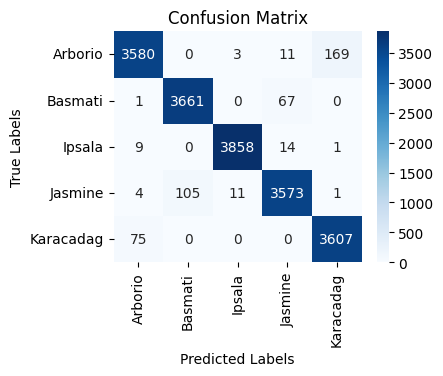

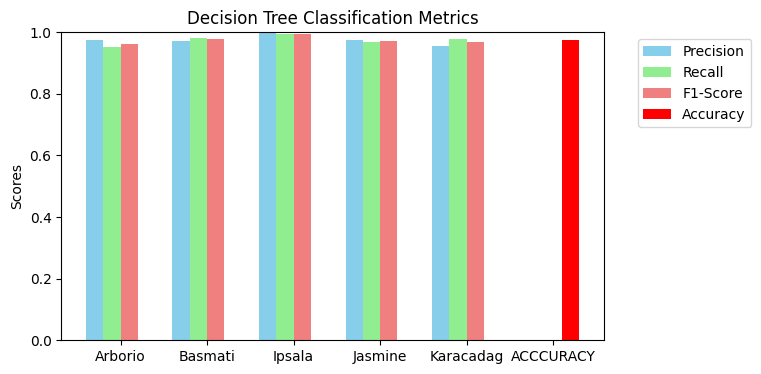

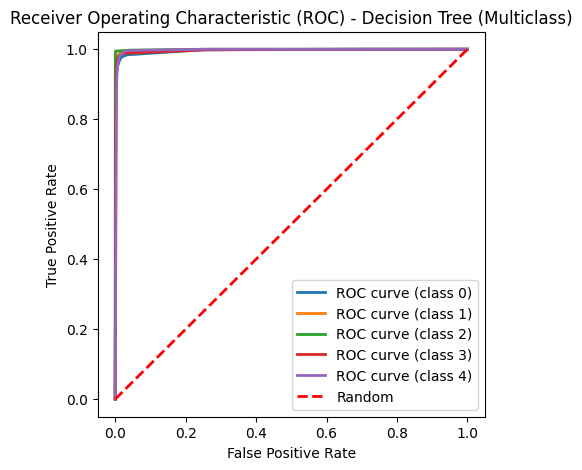

In [ ]:
# Decision Tree (Gini Index) with Feature Names Warning Fix

from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Build the Decision Tree with Gini Index criterion
clf_gini = DecisionTreeClassifier(criterion='gini', random_state=42)
clf_gini.fit(X_train.values, y_train)  # Use X_train.values instead of X_train

# Apply Reduced Error Pruning (REP)
path = clf_gini.cost_complexity_pruning_path(X_train.values, y_train)  # Use X_train.values instead of X_train
ccp_alphas, impurities = path.ccp_alphas, path.impurities

param_grid = {'ccp_alpha': ccp_alphas}
grid_search = GridSearchCV(estimator=DecisionTreeClassifier(criterion='gini', random_state=42),
                           param_grid=param_grid, cv=5)
grid_search.fit(X_train.values, y_train)  # Use X_train.values instead of X_train
best_ccp_alpha = grid_search.best_params_['ccp_alpha']

clf_gini_pruned = DecisionTreeClassifier(criterion='gini', ccp_alpha=best_ccp_alpha, random_state=42)
clf_gini_pruned.fit(X_train.values, y_train)  # Use X_train.values instead of X_train

# Perform RFE after Pruning
rfe = RFE(estimator=clf_gini_pruned, n_features_to_select=5)
rfe.fit(X_train.values, y_train)

# Get selected features
selected_features = X_train.columns[rfe.support_]

# Use only the selected features for training and testing
X_train_selected = rfe.transform(X_train.values)
X_test_selected = rfe.transform(X_test.values)

# Train the Decision Tree model using selected features after pruning and RFE
clf_final = DecisionTreeClassifier(criterion='gini', ccp_alpha=best_ccp_alpha, random_state=42)
clf_final.fit(X_train_selected, y_train)

# Predict on the test set using the selected features after pruning and RFE
y_pred_final = clf_final.predict(X_test_selected)

# Calculate accuracy
accuracy_final = accuracy_score(y_test, y_pred_final)
print(f'Accuracy after pruning and RFE: {accuracy_final}')

# Display classification report
print('\nClassification Report after pruning and RFE:')
print(classification_report(y_test, y_pred_final, target_names=class_names))

# Display confusion matrix
print('\nConfusion Matrix after pruning and RFE:')
c = confusion_matrix(y_test, y_pred_final)
print(c)

# Plot confusion matrix
plt.figure(figsize=(4, 3))
sns.heatmap(c, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# BAR chart
width = 0.2
x = np.arange(len(class_names) + 1)  # Added 1 for the common bar
classification_rep_logreg = classification_report(y_test, y_pred_final, target_names=class_names, output_dict=True)

# Extract precision, recall, f1_score, and accuracy
precision_logreg = [classification_rep_logreg[class_name]['precision'] for class_name in class_names]
recall_logreg = [classification_rep_logreg[class_name]['recall'] for class_name in class_names]
f1_score_logreg = [classification_rep_logreg[class_name]['f1-score'] for class_name in class_names]
accuracy_logreg = classification_rep_logreg['accuracy']

# Plot metrics
fig, ax = plt.subplots(figsize=(7, 4))

# Bar plot for precision
ax.bar(x - width, precision_logreg + [0], width, label='Precision', color='skyblue')

# Bar plot for recall
ax.bar(x, recall_logreg + [0], width, label='Recall', color='lightgreen')

# Bar plot for F1-score
ax.bar(x + width, f1_score_logreg + [0], width, label='F1-Score', color='lightcoral')

# Single common bar for accuracy
ax.bar(len(class_names) + 1.5 * width, [accuracy_logreg], width, color='red', label='Accuracy')

# Set y-axis limits
ax.set_ylim(0, 1)

# Set labels and title
ax.set_ylabel('Scores')
ax.set_title('Decision Tree Classification Metrics')
ax.set_xticks(x + width / 2)
ax.set_xticklabels(class_names + ['ACCCURACY'])
ax.legend()

# Place the legend outside the plot area
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

# ROC curve
# Binarize the output
y_test_binarized = label_binarize(y_test, classes=list(range(len(class_names))))

# Get decision function scores
y_scores = clf_final.predict_proba(X_test_selected)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting ROC curves for each class
plt.figure(figsize=(5, 5))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (class {})'.format(i))

plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Decision Tree (Multiclass)')
plt.legend(loc='lower right')
plt.show()


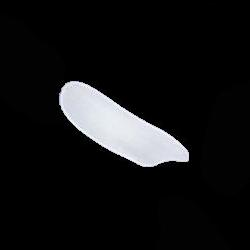

In [ ]:
from IPython.display import Image

# Replace 'local_image_path' with the path to your local image file
local_image_path = '/content/drive/MyDrive/New_Rice_image_Dataset75000/Rice_Image_Dataset/Jasmine/Jasmine (4584).jpg'

# Display the image
Image(filename=local_image_path)


Best Accuracy on Test Set: 0.9775466666666667

Classification Report:
              precision    recall  f1-score   support

     Arborio       0.97      0.96      0.97      3763
     Basmati       0.98      0.98      0.98      3729
      Ipsala       1.00      0.99      1.00      3882
     Jasmine       0.97      0.98      0.97      3694
   Karacadag       0.96      0.98      0.97      3682

    accuracy                           0.98     18750
   macro avg       0.98      0.98      0.98     18750
weighted avg       0.98      0.98      0.98     18750


Confusion Matrix:
[[3610    0    1    8  144]
 [   2 3654    0   73    0]
 [  11    0 3856   15    0]
 [   6   76    6 3605    1]
 [  78    0    0    0 3604]]


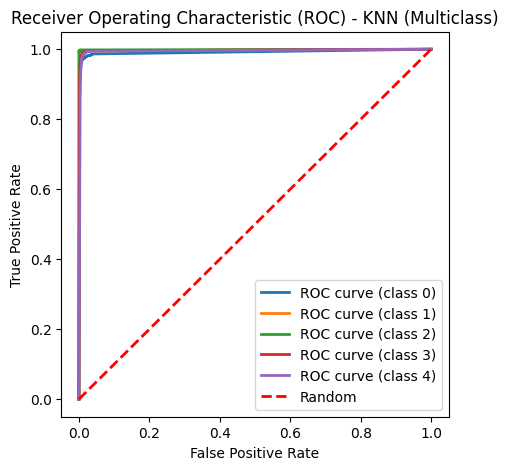

In [ ]:
#KNN
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler, label_binarize
import matplotlib.pyplot as plt

# Assuming X_train, X_test, y_train, y_test, class_names are defined

# Standardize the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the parameter grid for hyperparameter tuning
param_grid = {'n_neighbors': [3, 5, 7, 9, 11], 'weights': ['uniform', 'distance'], 'p': [1, 2]}

# Initialize KNN classifier
knn = KNeighborsClassifier()

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(knn, param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
best_k = best_params['n_neighbors']
best_weights = best_params['weights']
best_p = best_params['p']

# Train the KNN model with the best hyperparameters
knn_best = KNeighborsClassifier(n_neighbors=best_k, weights=best_weights, p=best_p)
knn_best.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = knn_best.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Best Accuracy on Test Set: {accuracy}')

# Display classification report and confusion matrix
print('\nClassification Report:')
print(classification_report(y_test, y_pred, target_names=class_names))

print('\nConfusion Matrix:')
c = confusion_matrix(y_test, y_pred)
print(c)

# ROC curve
# Binarize the output
y_test_binarized = label_binarize(y_test, classes=list(range(len(class_names))))

# Get decision function scores
y_scores = knn_best.predict_proba(X_test_scaled)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting ROC curves for each class
plt.figure(figsize=(5, 5))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (class {})'.format(i))

plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - KNN (Multiclass)')
plt.legend(loc='lower right')
plt.show()


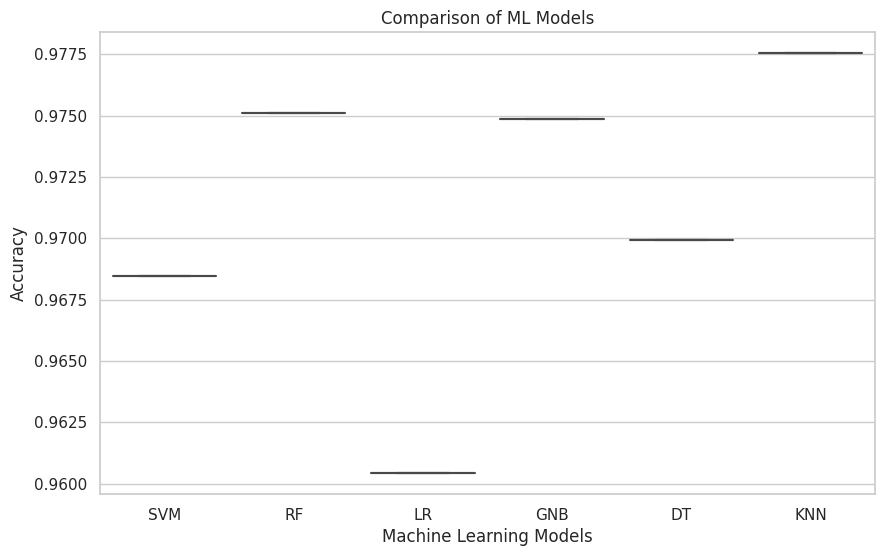

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

accuracy_svm = 0.96848
accuracy_rf = 0.9750933333333334
accuracy_lr = 0.9604266666666667
accuracy_scaled = 0.97488
accuracy_gnb = 0.96992
accuracy_knn = 0.9775466666666667

# List of model names and their corresponding accuracy scores
model_names = ['SVM', 'RF', 'LR', 'GNB', 'DT', 'KNN']
accuracy_scores = [accuracy_svm, accuracy_rf, accuracy_lr, accuracy_scaled, accuracy_gnb, accuracy]

# Create a DataFrame for visualization
data = {'Model': model_names, 'Accuracy': accuracy_scores}
df = pd.DataFrame(data)

# Create a box plot using seaborn
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
boxplot = sns.boxplot(x='Model', y='Accuracy', data=df, showfliers=False)
boxplot.set(title='Comparison of ML Models', xlabel='Machine Learning Models', ylabel='Accuracy')
plt.show()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

# Load the features from Excel
excel_path = '/content/drive/MyDrive/FEATURES_ALL_MORPHOLOGY.xlsx'
data = pd.read_excel(excel_path)

# Data Preprocessing
scaler = StandardScaler()
X = scaler.fit_transform(data[['area', 'perimeter', 'major_axis', 'minor_axis', 'eccentricity', 'convex_area',
                               'extent', 'solidity', 'orientation', 'equivalent_diameter', 'compactness',
                               'aspect_ratio', 'roundness']])
y = data['Label']

# Convert labels to numerical values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Reshape the features for CNN input (assuming a 1D vector for each sample)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Model Architecture
model = models.Sequential()
model.add(layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(len(label_encoder.classes_), activation='softmax'))

# Compile the Model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the Model
model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

# Predict using the trained model
y_pred_probabilities = model.predict(X_test)

# Extract the predicted classes
y_pred = np.argmax(y_pred_probabilities, axis=1)

# Evaluate the Model
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy}")


Epoch 1/50
1758/1758 [==============================] - 7s 4ms/step - loss: 0.1227 - accuracy: 0.9615 - val_loss: 0.0785 - val_accuracy: 0.9747
Epoch 2/50
1758/1758 [==============================] - 10s 6ms/step - loss: 0.0734 - accuracy: 0.9754 - val_loss: 0.0722 - val_accuracy: 0.9772
Epoch 3/50
1758/1758 [==============================] - 8s 5ms/step - loss: 0.0704 - accuracy: 0.9763 - val_loss: 0.0757 - val_accuracy: 0.9746
Epoch 4/50
1758/1758 [==============================] - 6s 3ms/step - loss: 0.0681 - accuracy: 0.9765 - val_loss: 0.0684 - val_accuracy: 0.9773
Epoch 5/50
1758/1758 [==============================] - 7s 4ms/step - loss: 0.0671 - accuracy: 0.9770 - val_loss: 0.0650 - val_accuracy: 0.9789
Epoch 6/50
1758/1758 [==============================] - 5s 3ms/step - loss: 0.0654 - accuracy: 0.9775 - val_loss: 0.0679 - val_accuracy: 0.9773
Epoch 7/50
1758/1758 [==============================] - 7s 4ms/step - loss: 0.0649 - accuracy: 0.9775 - val_loss: 0.0686 - val_accuracy